In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from typing import Optional
from torch.utils.data import DataLoader, TensorDataset

We write classes for linear and singular models that we are going to use train SGD

In [2]:
class SingModel(torch.nn.Module):
    def __init__(self, w0:float, d1:int, d2:int, in_features:int, cst: float, out_features:int,w_init: Optional[Tensor] = None) -> None:
         super(SingModel, self).__init__()
         self.w0 = w0
         self.d1 = d1
         self.d2 = d2
         self.cst = cst
         if w_init is not None:
            self.weight = torch.nn.Parameter(w_init)
         else:
            self.weight = torch.nn.Parameter(torch.randn((out_features, in_features)))

         
    def forward(self, input:Tensor):
        # Chose cst1 and cst2 such that K(1) = 0 and K'(1) = cst
        cst1 = - self.cst**(1/3)/2**(1/3)
        cst2 = (16*self.cst - 2**(2/3)*self.cst**(4/3))/64
        sing1 = (self.weight + self.w0)**self.d1
        sing2 = torch.sqrt((self.weight - self.w0 + cst1)**(2*self.d2) + cst2)
        return input * sing1 * sing2 

# Defining the Linear Model
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(1, 1)
        # Random weight initialization
        self.linear.weight.data.normal_()
    def forward(self, x):
        return self.linear(x)
    
# Training model

def train_model(model, data_loader, w_init: Optional[Tensor] = None, 
                linear=True, num_epochs = 1000, lr=0.01, momentum=0.9):
    # Loss tracking
    running_loss = []

    # Tracking weights
    if w_init is None:
         weights_over_epochs = []
    else:
         weights_over_epochs = [w_init.item()]

    # Loss and Optimizer
    loss_function = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), momentum=momentum, lr=lr)

    # Training the Model
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_x, batch_y in data_loader:
            # Forward pass
            y_pred = model(batch_x)
            loss = loss_function(y_pred, batch_y)

            # Backward pass and optimization
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Tracking the cumulative loss for the current epoch
            epoch_loss += loss.item()

        # Tracking loss and weight along epochs
        # Calculate average loss for the current epoch
        avg_epoch_loss = epoch_loss / len(data_loader)
        running_loss.append(avg_epoch_loss)
        if linear == True:
            current_weight = model.linear.weight.item()
        else:
            current_weight = model.weight.item() 
        weights_over_epochs.append(current_weight)

        if epoch % 10 == 0:
                        print(f'Epoch {epoch}, Loss: {loss.item()}, w: {current_weight}')
    return running_loss, weights_over_epochs

# Plot loss curve

def plot_loss_curve(loss_values):
    plt.plot(loss_values)
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

# Plot loss landscape

def plot_loss_landscape(model, x_data, y_data,
                        weight_range, weights_over_epochs, linear=False):

    # Computing the loss for each weight value in the range
    loss_landscape = []
    loss_function = nn.MSELoss()

    for weight in weight_range:
        # Updating the model's weight and fixed bias
        if linear == True:
            model.linear.weight.data.fill_(weight)
        else:
            model.weight.data.fill_(weight) 
        
        # Forward pass with the updated weight
        y_pred = model(x_data)
        
        # Computing the loss
        loss = loss_function(y_pred, y_data)
        loss_landscape.append(loss.item())

    # Plotting the loss landscape
    
    plt.plot(weight_range, loss_landscape, label='Loss Landscape')

    # Plotting the trajectory of the weights during training
    plt.plot(weights_over_epochs, [loss_landscape[np.argmin(np.abs(weight_range - w))] for w in weights_over_epochs], 'ro-', label='Training Path', markersize=3)
    plt.title('Weight Dynamics on Loss Landscape')
    plt.yscale("log")
    plt.xlabel('Weight')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


Train a Linear model and visualise the loss curve and visualise the training dynamics on the loss landscape (for sanity check)

Epoch 0, Loss: 1.3114222288131714, w: -0.06669075042009354
Epoch 10, Loss: 0.09348979592323303, w: 0.1763247549533844
Epoch 20, Loss: 5.360281944274902, w: -0.0353110171854496
Epoch 30, Loss: 6.151021957397461, w: 0.04302680492401123
Epoch 40, Loss: 2.551607370376587, w: -0.11391668021678925
Epoch 50, Loss: 0.008599737659096718, w: 0.02462535724043846
Epoch 60, Loss: 2.1367835998535156, w: 0.25205329060554504
Epoch 70, Loss: 0.1371261030435562, w: 0.25979048013687134
Epoch 80, Loss: 0.4532037079334259, w: 0.23398149013519287
Epoch 90, Loss: 0.26799145340919495, w: 0.004388569388538599


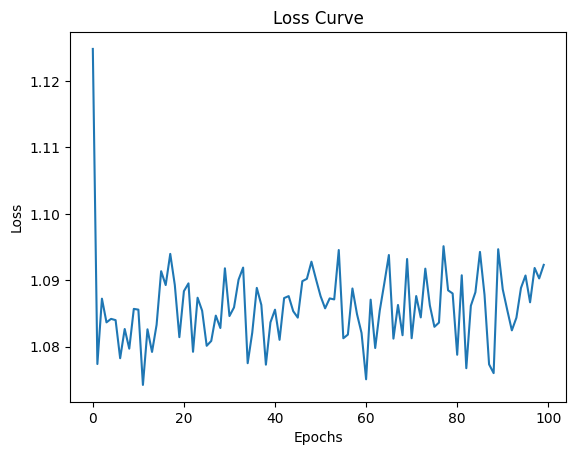

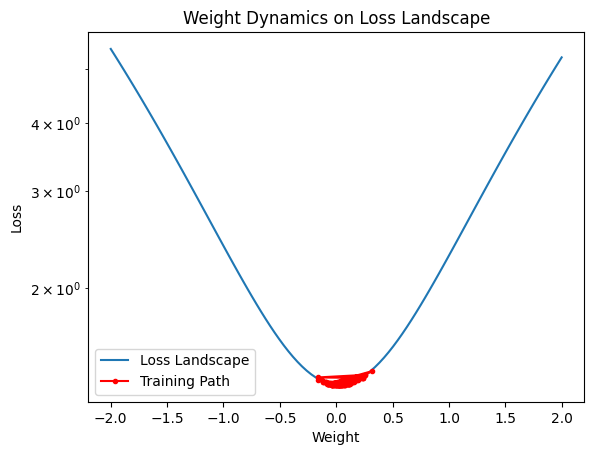

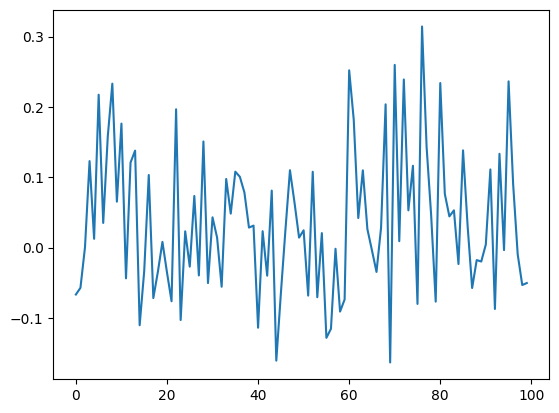

In [3]:
from torch.distributions import Cauchy 

# Parameters
torch.manual_seed(42) # for reproducibility
num_samples = 1000
num_epochs = 100
batch_size = 1
lr = 0.001
momentum = 0.9

x_data = torch.normal(0, 1, (num_samples, 1))
y_data = torch.normal(0, 1, (num_samples, 1))
dataset = TensorDataset(x_data, y_data)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Train function
model = LinearModel()
loss_values, weights_over_epochs =  train_model(model, data_loader, num_epochs = num_epochs, lr=lr, momentum=momentum)
plot_loss_curve(loss_values)

# Plot loss landscape
weight_range = np.linspace(-2, 2, 100)
model = LinearModel()
plot_loss_landscape(model, x_data, y_data, 
                        weight_range, weights_over_epochs, linear=True)
plt.plot(weights_over_epochs)

Train a singular model, plot loss curve and loss landscape

Epoch 0, Loss: nan, w: nan
Epoch 10, Loss: nan, w: nan
Epoch 20, Loss: nan, w: nan
Epoch 30, Loss: nan, w: nan
Epoch 40, Loss: nan, w: nan
Epoch 50, Loss: nan, w: nan
Epoch 60, Loss: nan, w: nan
Epoch 70, Loss: nan, w: nan
Epoch 80, Loss: nan, w: nan
Epoch 90, Loss: nan, w: nan


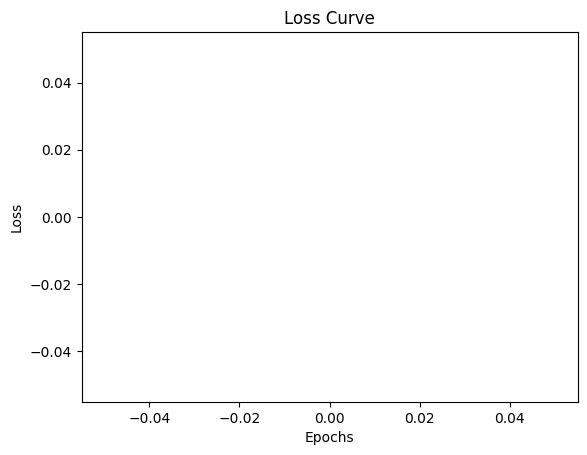

-2.0


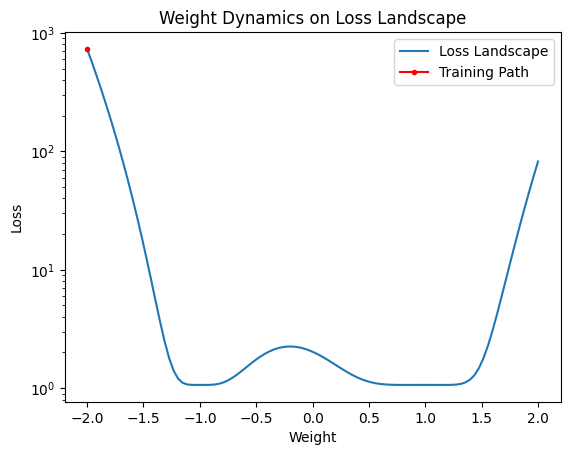

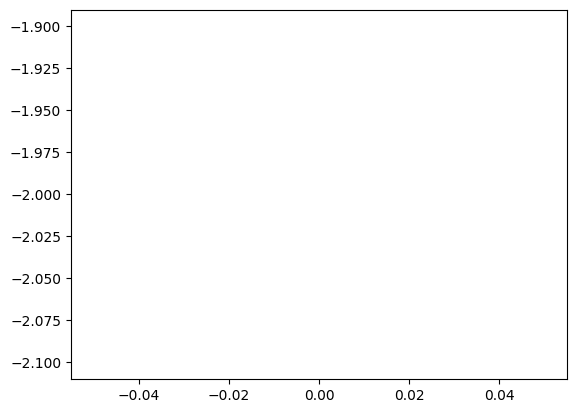

In [21]:
from torch.distributions import Cauchy 
from torch.distributions import StudentT

# Noise
#StudentT(df=1,loc=0,scale=1).sample((batch_size,1))
#torch.normal(0, 1, (batch_size, 1))
# Pramaters
torch.manual_seed(42) # for reproducibility
lr = 0.001
w_init = -2
num_epochs = 100
num_samples = 1000
batch_size = 5
cst = 0
momentum = 0

# Generate data
w_init = torch.Tensor([[w_init]])
torch.manual_seed(42) # for reproducibility
x_data = torch.normal(0, 1, (num_samples, 1))
y_data = torch.normal(0, 1, (num_samples, 1))
dataset = TensorDataset(x_data, y_data)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training
model = SingModel(w0=1.0, d1=2, d2=3, in_features=1, out_features=1, 
                  cst=cst, w_init=w_init)
loss_values, weights_over_epochs =  train_model(model, data_loader, w_init=w_init,linear=False, num_epochs = num_epochs, lr=lr, momentum=momentum)
plot_loss_curve(loss_values)
print(weights_over_epochs[0])

# Plot loss landscape
weight_range = np.linspace(-2, 2, 100)
model = SingModel(w0=1.0, d1=2, d2=3, in_features=1, out_features=1, 
                  cst=cst, w_init=w_init)  # create a model instance
plot_loss_landscape(model, x_data, y_data,
                        weight_range, weights_over_epochs, linear=False)
plt.plot(weights_over_epochs)

Run different experiments

Epoch 0, Loss: 0.2998841404914856, w: 0.9871740341186523
Epoch 10, Loss: 0.9417693018913269, w: 0.9629220962524414
Epoch 20, Loss: 1.23112154006958, w: 0.9476243853569031
Epoch 30, Loss: 1.2573496103286743, w: 0.9534527659416199
Epoch 40, Loss: 1.0191246271133423, w: 0.955308735370636
Epoch 50, Loss: 1.5655251741409302, w: 0.957705020904541
Epoch 60, Loss: 1.5267919301986694, w: 0.9618880748748779
Epoch 70, Loss: 0.8152542114257812, w: 0.9334262013435364
Epoch 80, Loss: 1.4212315082550049, w: 0.9654889702796936
Epoch 90, Loss: 1.389840006828308, w: 0.9515315294265747
Epoch 100, Loss: 1.924424409866333, w: 0.9445701241493225
Epoch 110, Loss: 0.26812952756881714, w: 0.9487285017967224
Epoch 120, Loss: 2.024564266204834, w: 0.9488623738288879
Epoch 130, Loss: 0.3332434594631195, w: 0.9478985071182251
Epoch 140, Loss: 0.5558046698570251, w: 0.9581272602081299
Epoch 150, Loss: 0.41336631774902344, w: 0.9487113952636719
Epoch 160, Loss: 1.6915162801742554, w: 0.9522406458854675
Epoch 170, Lo

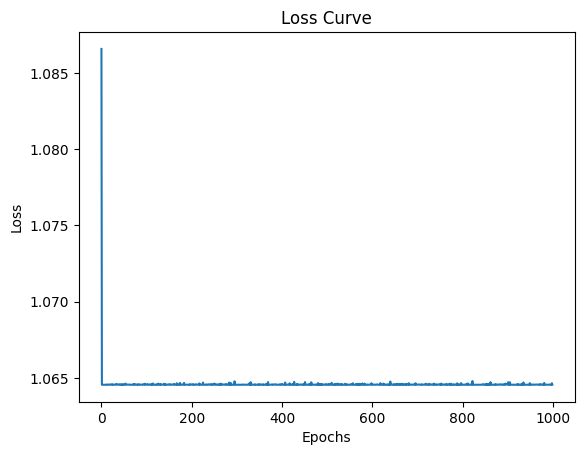

-1.2999999523162842


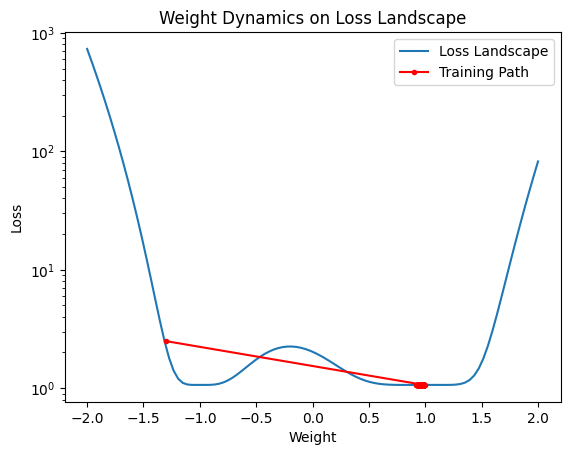

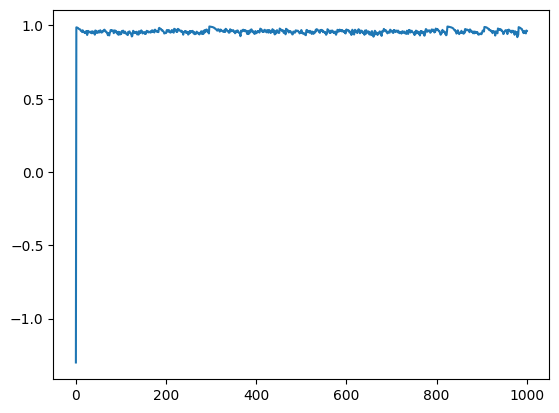

In [19]:
from torch.distributions import Cauchy 
from torch.distributions import StudentT

# Noise
#StudentT(df=1,loc=0,scale=1).sample((batch_size,1))
#torch.normal(0, 1, (batch_size, 1))

# Pramaters
torch.manual_seed(42) # for reproducibility
lr = 0.01
w_init = -1.3
batch_size = 5
momentum = 0.9

num_epochs = 100
num_samples = 1000

# Generate data
w_init = torch.Tensor([[w_init]])
torch.manual_seed(42) # for reproducibility
x_data = torch.normal(0, 1, (num_samples, 1))
y_data = torch.normal(0, 1, (num_samples, 1))
dataset = TensorDataset(x_data, y_data)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training
model = SingModel(w0=1.0, d1=2, d2=3, in_features=1, out_features=1, cst=cst, w_init=w_init)

loss_values, weights_over_epochs =  train_model(model, data_loader, w_init=w_init,linear=False, num_epochs = num_epochs, lr=lr, momentum=momentum)
plot_loss_curve(loss_values)
print(weights_over_epochs[0])

# Plot loss landscape
weight_range = np.linspace(-2, 2, 100)
model = SingModel(w0=1.0, d1=2, d2=3, in_features=1, out_features=1, cst=cst, w_init=w_init)  # create a model instance
plot_loss_landscape(model, x_data, y_data,
                        weight_range, weights_over_epochs, linear=False)
plt.plot(weights_over_epochs)